In [247]:
using LinearAlgebra, Plots, Statistics, LaTeXStrings
using Plots.PlotMeasures, Revise
using Zygote

In [248]:
Δ = 0.1
A = [0.98 Δ; 0 0.95];
B = [0; Δ;;];
rₓ, rᵤ = size(B)
C = I;
D = 0;

V = [0.05;;] 
W = [0.2 0; 0 0.1]
Q = 5.0 * I(rₓ)
Q = [1 0; 0 .5]
R = 1.0 * I(rᵤ)
;

In [249]:
θ = 1/6
function f(x::Vector{Float64}, u::Vector{Float64})
    x⁺ = A * x + B * u + [θ * x[2] ^ 2; θ * tanh(x[1]) * u[1]]
    return x⁺
end

function f_dataGen_CL(x₀::Vector{Float64}, K::Matrix{Float64}, N::Int)
    X = zeros(Float64, size(K)[2], N+1)
    U = zeros(Float64, size(K)[1], N)
    X[:,1] = x₀
    for j=1:N
        U[:,j] = K * X[:,j] + sqrt(V) * randn(rᵤ,)
        X[:,j+1] = f(X[:,j], U[:,j])+ sqrt(W) * randn(rₓ,)
    end
    return X[:,1:end-1], U
end
;


In [250]:
function ∇ₓf(x₀::Vector{Float64}, u₀::Vector{Float64})
	Zygote.jacobian(x -> f(x, u₀), x₀)[1]
end
function ∇ᵤf(x₀::Vector{Float64}, u₀::Vector{Float64})
	Zygote.jacobian(u -> f(x₀, u), u₀)[1]
end

∇ᵤf (generic function with 1 method)

In [251]:
A_local, B_local = ∇ₓf(zeros(Float64, 2),[0.0]), ∇ᵤf(zeros(Float64, 2),[0.0])

([0.98 0.1; 0.0 0.95], [0.0; 0.1;;])

In [252]:
plt = plot(
    framestyle = :box,
    yguidefontsize = 10,
    xguidefontsize = 10,
    xtickfontsize = 8,
    ytickfontsize = 8,
    palette = :seaborn_muted,
    foreground_color_legend = nothing,
    legendfontsize=8,
    legend=:outerbottom,
    fontfamily = "Computer Modern",
    markersize = 2,
);

In [253]:
using RobustWithLessShifts

In [254]:
function XU_to_params(X, U)
    N = size(X)[2]
    params = zeros(2, N)
    ABs = fill([], N)
    for k in 1:N
        A_loc, B_loc = ∇ₓf(X[:,k],U[:,k]), ∇ᵤf(X[:,k],U[:,k])
        params[:,k] = [A_loc[1,2], B_loc[2,1]]
        ABs[k] = [A_loc, B_loc]
    end
    return params, ABs
end



XU_to_params (generic function with 1 method)

In [255]:
Σ_data = [.1 0; 0 .1] * 5
Σ_U_data = [0.1;;] * 5

1×1 Matrix{Float64}:
 0.5

In [256]:
Nₛ = 500
Σ_grid = Σ_data
X_grid = sqrt(Σ_data) * randn(rₓ, Nₛ)
U_grid = sqrt(Σ_U_data) * randn(rᵤ, Nₛ);

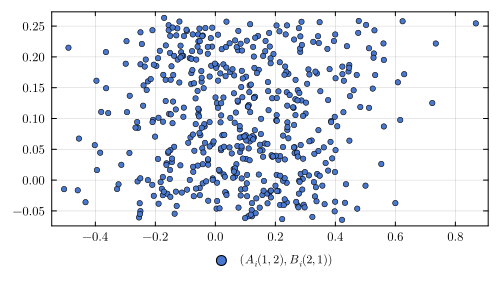

In [257]:
params_grid, ABs = XU_to_params(X_grid, U_grid)
plot_params_grid = scatter(plt, params_grid[1,:], params_grid[2,:], 
markersize = 3, size = (500, 300), label = L"(A_i(1,2),B_i(2,1))") 

In [258]:
K_LQR = Standard_LQR_SDP(A_local, B_local, Q, R, zeros(Float64, rₓ, rₓ), V);

Lyupanov condition error: (L∞ norm) is 4.996021598811448e-9


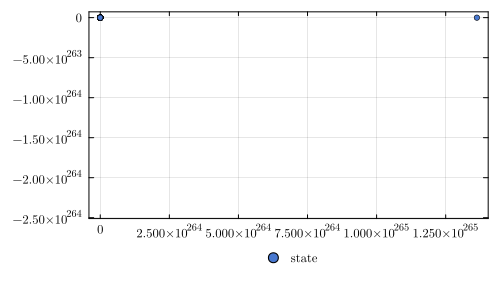

In [259]:
N = 500
x₀ = zeros(Float64, 2,)
X, U = f_dataGen_CL(x₀, K_LQR, N)
scatter(plt, X[1,:], X[2,:], markersize = 3, size = (500, 300), label="state") 

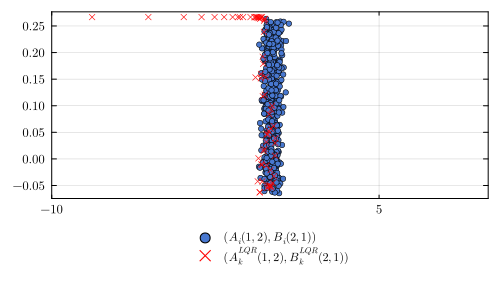

In [260]:
params, _ = XU_to_params(X, U)
plot_params_LQR = scatter(plot_params_grid, params[1,:], params[2,:], markersize = 3, size = (500, 300),
label = L"(A_k^{LQR}(1,2),B_k^{LQR}(2,1))", 
markershape = :xcross, color = "red", xlims = (-10,10))
plot!(plot_params_LQR, xticks=xticks(plot_params_LQR[1])[1][1:3:end])


In [261]:
K_Robust = Quadratically_Stable_LQR_SDP(ABs, Q, R, zeros(Float64, rₓ, rₓ), V)

1×2 Matrix{Float64}:
 -0.41253  -0.0345577

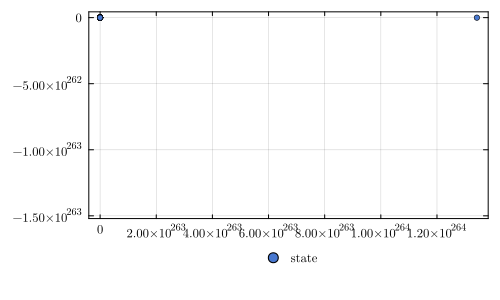

In [262]:
N = 500
x₀ = zeros(Float64, 2,)
X, U = f_dataGen_CL(x₀, K_Robust, N)
plot_data_exp = scatter(plt, X[1,:], X[2,:], markersize = 3, size = (500, 300), label = "state") 

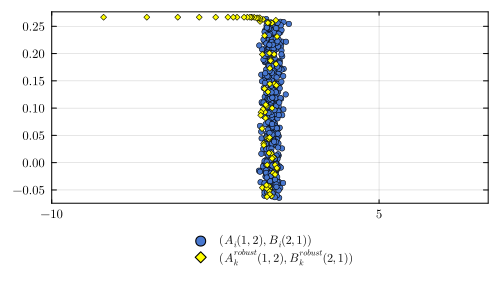

In [263]:
params, _ = XU_to_params(X, U)
plot_params_robust = scatter(plot_params_grid, params[1,:], params[2,:], markersize = 3, 
size = (500, 300),label = L"(A_k^{robust}(1,2),B_k^{robust}(2,1))", 
markershape = :diamond, color = "yellow", xlims = (-10,10))
plot!(plot_params_robust, xticks=xticks(plot_params_robust[1])[1][1:3:end])


In [264]:
γ = 10
K_Robust_dataConforming = Quadratically_Stable_State_Input_Data_Conforming_LQR_SDP(ABs, Q, R, zeros(Float64, rₓ, rₓ), V, X_grid, U_grid, γ)

1×2 Matrix{Float64}:
 0.0516585  -3.67976

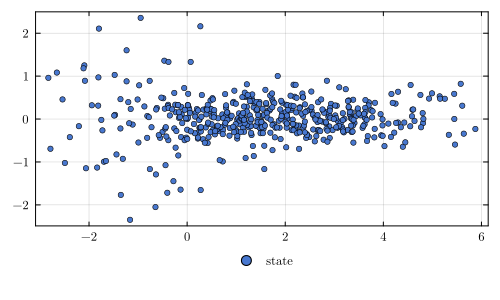

In [265]:
N = 500
x₀ = zeros(Float64, 2,)
X, U = f_dataGen_CL(x₀, K_Robust_dataConforming, N)
plot_data_exp = scatter(plt, X[1,:], X[2,:], markersize = 3, size = (500, 300), label = "state") 

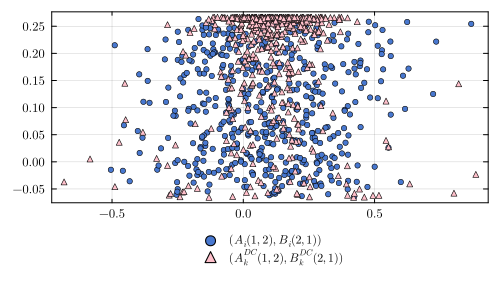

In [273]:
params, _ = XU_to_params(X, U)
plot_params_dataConforming = scatter(plot_params_grid, params[1,:], params[2,:], 
markersize = 3, size = (500, 300), label = L"(A_k^{DC}(1,2),B_k^{DC}(2,1))", 
markershape = :utriangle, color = "pink")
plot!(plot_params_dataConforming, xticks=xticks(plot_params_dataConforming[1])[1][1:2:end])

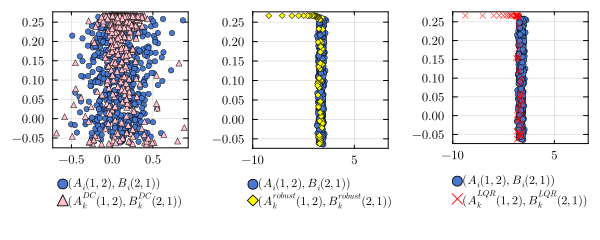

In [276]:

MarkerSize = 2   

width = 600
height = 240
Fig1 = plot(plot_params_dataConforming, plot_params_robust, plot_params_LQR, 
layout = (1,3), size = (width, height))

In [277]:
Fig1
savefig("figs/distShifts.pdf")

"/Users/mohammadramadan/Documents/GitHub/robust-less-dist-shifts/figs/distShifts.pdf"